In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = '1'


In [2]:


from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt



from utils import generate_bpr_dataset, generate_bpr_dataset_with_click_data
from evaluation import Evaluate
from bpr_mf import bprMf, bprMFDataloader, bprMFWithClickDebiasing

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
interactions = pd.read_csv('movielens_1m_ratings.csv')[["user", "item", "rating"]]
interactions["relevant"] = interactions["rating"].apply(lambda r: int(r >= 4))
zero_based_indexing = {v: K for K, v in enumerate(interactions["item"].unique())}
interactions["item"] = interactions["item"].map(zero_based_indexing)

In [5]:
interactions.groupby("user").agg({"item": list})

,item
user,
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,"[53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 6..."
3,"[175, 176, 58, 177, 178, 179, 180, 64, 181, 18..."
4,"[63, 64, 208, 209, 210, 44, 48, 113, 124, 127,..."
5,"[218, 219, 220, 221, 222, 223, 224, 225, 59, 2..."
...,...
6036,"[1892, 2470, 1326, 558, 240, 33, 97, 450, 876,..."
6037,"[97, 256, 1118, 1120, 1492, 128, 2072, 1253, 6..."
6038,"[1615, 153, 1509, 1033, 206, 535, 1528, 1340, ..."


## Developing a MF model based using BPR opt


Now we'll generalize the previous implementation using implicit feedback data and applying BPR (Bayesian personalized ranking) loss function, so that the model is capable of building personalzied rankings for users

### Step 1 : adapt training data for BPR


BPR expects implicit feedback data and relative ordering in the training dataset

In [6]:

zero_based_indexing = {v: K for K, v in enumerate(interactions["item"].unique())}
interactions["item"] = interactions["item"].map(zero_based_indexing)

bpr_df = generate_bpr_dataset(interactions)

### Step 2: Create a MF model using BPR loss function

In [7]:
data_bpr = bprMFDataloader(bpr_df)


# Calculate split lengths
train_len = int(0.7 * len(data_bpr))
test_len = len(data_bpr) - train_len


train_data, test_data = random_split(data_bpr, [train_len, test_len])



In [8]:


dataloader_bpr_train = DataLoader(train_data, batch_size=256, shuffle=True)
dataloader_bpr_test = DataLoader(test_data, batch_size=256, shuffle=True)

In [9]:

n_users = bpr_df.user.max() + 1
n_items = bpr_df.pos_item.max() + 1

In [10]:
n_users, n_items

(np.int64(6041), np.int64(3706))

In [11]:



model = bprMf(
                num_users=n_users,
                num_items=n_items,
                factors=50,
                reg_lambda=5e-4,
                n_epochs=10).to(device)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses = model.fit(dataloader_bpr_train, optimizer)

In [13]:
train_losses

[0.4727620575611073,
 0.3431634537317199,
 0.3349467927366404,
 0.3337367294039543,
 0.33353982930645426,
 0.33349864187762185,
 0.3334943244291616,
 0.3334864118290267,
 0.33349642026794896,
 0.33350385475420213]

In [14]:
test_loss = model.evaluate(dataloader_bpr_test)

In [15]:
test_loss

0.3354541251977669

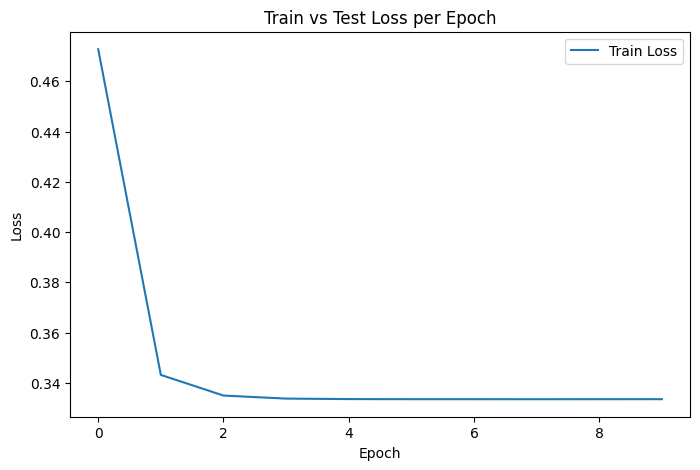

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss per Epoch')
plt.legend()
plt.show()

In [17]:
test_set = test_data.dataset.data

In [18]:
test_set

,user,pos_item,neg_item
0,1,0,230
1,1,0,1318
2,1,0,2527
3,1,1,1371
4,1,1,3658
...,...,...,...
3000622,6040,152,68
3000623,6040,152,2257
3000624,6040,26,400
3000625,6040,26,2181


In [19]:
users = torch.tensor(list(test_data.dataset.data.user.drop_duplicates()), device=device)

In [20]:
candidates = torch.tensor(list(test_data.dataset.data.pos_item.drop_duplicates()), device=device)

In [21]:
%%time
item_recs = model.predict(users, candidates)[0]

CPU times: user 13.4 ms, sys: 10 ms, total: 23.4 ms
Wall time: 22.8 ms


In [22]:
mask = torch.randint(0, 2, (users.shape[0], candidates.shape[0]), device=device) * 2 - 1

In [27]:
%%time
filtered_recs = model.predict(users, candidates, mask)[0]

CPU times: user 7.44 ms, sys: 18.1 ms, total: 25.5 ms
Wall time: 24 ms


In [23]:
evaluator = Evaluate(model, test_data, interactions, k=20)

In [24]:
evaluator.MAP_at_k()

0.07403741691189153

## Developing a BPR variant for click position debiasing

In [25]:
interactions["click"] = np.random.randint(0, 20, size=len(interactions))

In [26]:
interactions

,user,item,rating,relevant,click
0,1,0,5,1,2
1,1,1,3,0,6
2,1,2,3,0,2
3,1,3,4,1,16
4,1,4,5,1,14
...,...,...,...,...,...
1000204,6040,772,1,0,1
1000205,6040,1106,5,1,18
1000206,6040,365,5,1,2
1000207,6040,152,4,1,13


In [27]:

bpr_df_click = generate_bpr_dataset_with_click_data(interactions)

In [28]:
bpr_df_click

,user,pos_item,click_position,neg_item
0,1,0,2,1588
1,1,0,2,2579
2,1,0,2,802
3,1,1,6,2030
4,1,1,6,3538
...,...,...,...,...
3000622,6040,152,13,1600
3000623,6040,152,13,1999
3000624,6040,26,4,3597
3000625,6040,26,4,2229


In [29]:
from bpr_mf import bprMFLClickDebiasingDataloader, bprMFWithClickDebiasing

In [30]:
data_bpr = bprMFLClickDebiasingDataloader(bpr_df_click)


train_len = int(0.7 * len(data_bpr))
test_len = len(data_bpr) - train_len


train_data, test_data = random_split(data_bpr, [train_len, test_len])



dataloader_bpr_train = DataLoader(train_data, batch_size=256, shuffle=True)
dataloader_bpr_test = DataLoader(test_data, batch_size=256, shuffle=True)

In [31]:
n_users = bpr_df_click.user.max() + 1
n_items = bpr_df_click.pos_item.max() + 1

In [32]:
model = bprMFWithClickDebiasing(
                num_users=n_users,
                num_items=n_items,
                factors=50,
                reg_lambda=1e-3,
                n_epochs=10).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [33]:

train_losses = model.fit(dataloader_bpr_train, optimizer)

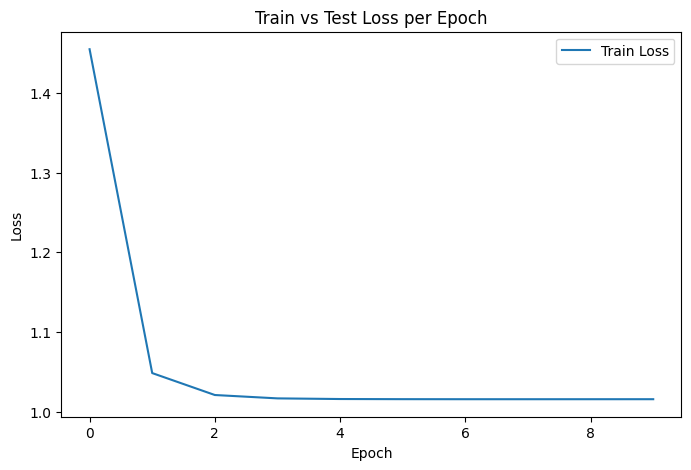

In [34]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss per Epoch')
plt.legend()
plt.show()

In [35]:
test_loss = model.evaluate(dataloader_bpr_test)

In [36]:
test_loss

1.020030519841644

In [37]:
evaluator = Evaluate(model, test_data, interactions, k=20)

In [38]:
evaluator.MAP_at_k()

0.06997351358585503